# Data-Mining Challenge 

Im ersten Teil haben wir erstmal alles gelassen wie zuvor, damit wir den Vergleich zu unserer Abgabe hatten und sehen konnten, ob sich unsere Werte verbesserten.
Dabei haben wir primär an der Feature Selection gearbeitet und haben verschiedene Varianten ausprobiert, die wir dann auskommentiert haben und sind im Endeffekt beim ExtraTreesClassifier gelandet. Dieser hat unsere Werte deutlich verbessert. 
Anschließend haben wir im zweiten Teil haben wir dann unsere Verbesserungen genutzt, um unseren Random Forest mit den besten Features zu trainieren und anschließend die Test Daten zur Analyse genutzt.

## 1)

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate
import pymrmr 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
params = pd.read_hdf("./image_parameters_smd_train.hdf5")

In [3]:
y = np.concatenate([np.ones(len(params[params.corsika_run_header_particle_id==1])), np.zeros(len(params[params.corsika_run_header_particle_id==14]))])
forbidden_columns = 'ceres_|mc_|corsika_|run_|source_position_|pointing_|aux_|event_num|incident_angle'

X = params.filter(regex=f'^(?!{forbidden_columns}).*$')

In [4]:
#mRMR
#index = pymrmr.mRMR(X, "MIQ", 5)
#index = X.drop(index, axis=1).keys()
#X = X[X.columns.difference(index)]
#X.head()

In [5]:
#RFE
#model = LogisticRegression(solver="lbfgs")
#rfe = RFE(model, 5)
#fit = rfe.fit(X, y)
#index = fit.support_
#index = X.drop(X.keys()[index == True], axis=1).keys()
#X = X[X.columns.difference(index)]
#X.head()

In [6]:
#Feature Importance 
model = ExtraTreesClassifier(n_estimators=100)
model.fit(X, y)
index = np.argpartition(model.feature_importances_, -5)[:-5]
print(index)
X = X[X.columns.difference(X.keys()[index])]
print(f"Die neuen Features sind {X.keys()}.")

[ 5 13  1 14  4 12 10  9  2 11  6 16]
Die neuen Features sind Index(['concentration_cog', 'concentration_two_pixel', 'length',
       'photoncharge_shower_mean', 'width'],
      dtype='object').


In [7]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2)

In [8]:
np.random.seed(12)
rf1 = RandomForestClassifier(n_estimators=1, min_samples_leaf=5, n_jobs=-1)
rf10 = RandomForestClassifier(n_estimators=10, min_samples_leaf=5, n_jobs=-1)
rf100 = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, n_jobs=-1)
rfx = RandomForestClassifier(n_estimators=150, min_samples_leaf=7, n_jobs=-1)

score = cross_validate(rf1, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest n=1   {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))
score = cross_validate(rf10, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest n=10  {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))
score = cross_validate(rf100, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest n=100 {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))
score = cross_validate(rfx, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest n=150 {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

ROC AUC Random Forest n=1   0.594 +/- 0.011
ROC AUC Random Forest n=10  0.635 +/- 0.009
ROC AUC Random Forest n=100 0.644 +/- 0.006
ROC AUC Random Forest n=150 0.641 +/- 0.007


In [9]:
rfx.fit(X_train, y_train)
y_prediction_proba = rfx.predict_proba(X_test)

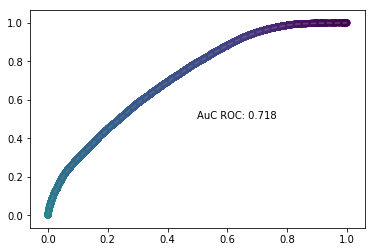

In [10]:
auc = roc_auc_score(y_test, y_prediction_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_proba[:, 1])
plt.scatter(fpr, tpr, c=thresholds)
plt.plot(fpr, tpr, '--', color='gray', alpha=0.5)
plt.text(0.5, 0.5, f'AuC ROC: {auc:0.03f}')
None

## 2)

In [11]:
#trainingsdata
X_train = params.filter(regex=f'^(?!{forbidden_columns}).*$') 
y_train = np.concatenate([np.ones(len(params[params.corsika_run_header_particle_id==1])), np.zeros(len(params[params.corsika_run_header_particle_id==14]))]) 

#feature selection
model = ExtraTreesClassifier(n_estimators=100)
model.fit(X_train, y_train)
index = np.argpartition(model.feature_importances_, -5)[:-5]
X_train = X_train[X_train.columns.difference(X_train.keys()[index])]

#train forest
rfx = RandomForestClassifier(n_estimators=150, min_samples_leaf=7, n_jobs=-1)
rfx.fit(X_train, y_train)

#read test data and select same features as training data
X_test = pd.read_hdf("./image_parameters_smd_test.hdf5")
X_test = X_test[X_test.columns.difference(X_test.keys()[[1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14]])]

#evalute prediction probability values
y_prediction_proba = rfx.predict_proba(X_test)

#save them into a file
np.savetxt("predicted_labels.csv", y_prediction_proba[:,1], delimiter=",")
